# Import continuous data from .continuous Openephys raw files

In [ ]:
""" Takes the .npy with raw data from openephys2npy, and create baseline and OF epochs 

Input: 
    'SERTXXXX/npys_dir + structure.npy' 
    
    Of .npy matrices by structure, with 
        - Channels at 30 KHz
        - All channels with mean subtracted
        - Low-passed at 300 Hz
        - Median subtracted
        
Output:
    'SERT/SERTXXXX/npys/baselines_epochs.npy'
    
    1. Epoched data from 3s before to after (total = 6 s) each center entrance. 
    2. Epoched baselines (mouse in OF periphery) of 3s lenght (total = 3 s).
    
        
Baseline epochs are obtaines from:
    
    'SERT/ALL/npys/baselines.dict'
    
    * A dictionary with n baselines for each mouse
    * Sampled at 30 Hz 
    
    
Written by Mauricio Aspé-Sánchez. Copyleft 2020.

""" 

#### Import the required modules

In [1]:
# Import required modules
#import glob
#import sys
import time
import pickle
import numpy as np
import pandas as pd
import physig as ps
from scipy import signal
from matplotlib import pyplot as plt

#### Get the mouse name and create the file name and folder paths

In [2]:
IDs = {'SERT1597': {}} #,
  #'SERT1659': {}}

In [ ]:
,
 'SERT1665': {},
 'SERT1668': {},
 'SERT1678': {},
 'SERT1908': {},
 'SERT1984': {},
 'SERT1985': {},
 'SERT2013': {},
 'SERT2014': {},
 'SERT2018': {},
 'SERT2024': {}}

#### Import info dictionary

In [3]:
#IDs = pickle.load(open('/home/maspe/filer/scripts/preprocessing/IDs.dict'))['dict']
baselines_all = pickle.load(open('/home/maspe/filer/SERT/ALL/npys/baselines.dict', 'rb')) #, encoding='latin1')
#info = pickle.load(open(npys_dir + ID + '.info', 'rb'))

## Main loop

### Epoching the continuos data

For baseline:<br>
Define a windows of $3 s$, beginning at each point from baselines dictionary. Points are at $30 Hz$, thus multiplied by $1000$ to yield a $30 KHz$ resolution.

For OF:<br>
Define windows of $3 s$. Create a windows equals to $3 \times fs$; $fs = 30 KHz$. Collect $3 s$ before and $3 s$ after each of the mouse's entrances to the center of the OF.

Save at '/home/maspe/filer/SERT/SERTXXXX/npys/mPFC_epochs'.


Processing mouse SERT1597 (# 1)...
Number of entrances: 16
Loading NAC...
Plotting NAC's epochs...
Plotting NAC's baselines...
Loading BLA...
Plotting BLA's epochs...
Plotting BLA's baselines...
Loading mPFC...
Plotting mPFC's epochs...


/usr/local/lib/python2.7/dist-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Plotting mPFC's baselines...
Loading vHip...
Plotting vHip's epochs...
Plotting vHip's baselines...
Saving epoched dictionary...
Epochs extracted in 5.06 min.

Done!


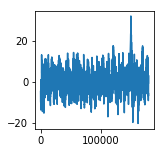

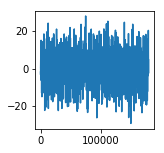

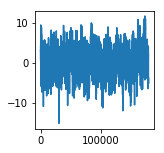

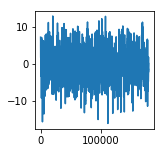

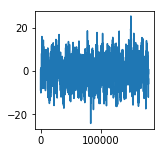

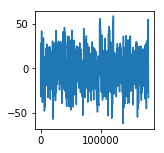

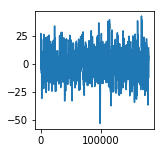

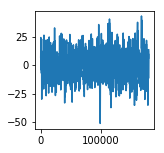

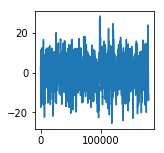

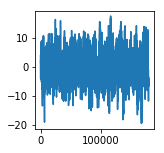

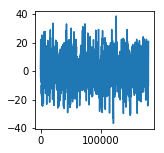

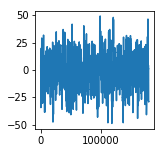

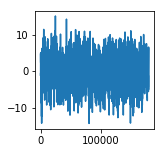

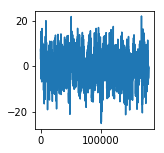

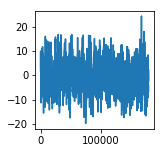

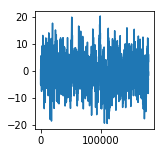

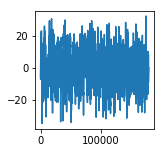

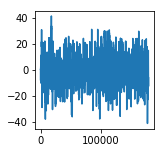

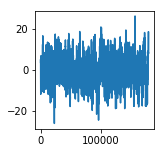

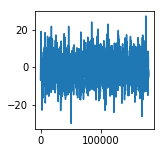

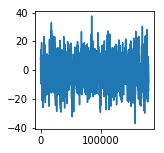

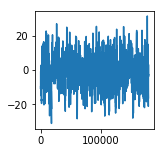

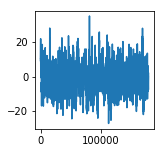

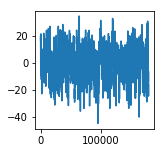

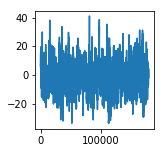

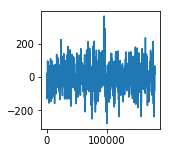

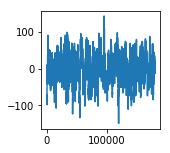

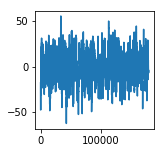

In [4]:
# Defining time windows as 3 seconds before plus 3 second after center entrances
fs = 30000
secs = 3
window = int(fs) * secs

n_baselines = 25

iterator = 1
for mouse in IDs.keys():
    clock = time.time()
    print('Processing mouse {} (# {})...'.format(mouse, iterator))
    
    ### Setting working file and paths
    files_dir = '/home/maspe/filer/SERT/' + mouse + '/continuous/'
    npys_dir  = '/home/maspe/filer/SERT/' + mouse + '/npys/'
    figs_dir  = '/home/maspe/filer/SERT/' + mouse + '/figs/'
    
    # Read the entrances times
    df = pd.read_excel(files_dir + 'entradas.xlsx', sheet_name=0, header=None, names=["locs"])
    entrances_times = np.array(df['locs'].tolist(), dtype='int') * 30 # From 1 to 30 KHz
    n_epochs = len(entrances_times)
    print('Number of entrances: {}'.format(n_epochs))

    # Defining baselines as 3 s windows
    baselines = baselines_all[mouse] * 1000 # From 30 to 30,000 Hz
    
    
    structures = {'mPFC': {}, 'NAC': {}, 'BLA': {}, 'vHip': {}}
    for structure in structures.keys():
        print('Loading {}...'.format(structure))
        data = np.load(npys_dir + structure + '.npy')
        n_channels = data.shape[0]
    
        print('Collecting epochs...')   
        data_epochs    = np.zeros((n_channels, window * 2, n_epochs))
        data_baselines = np.zeros((n_channels, window, n_baselines))

        for channel in range(n_channels):
            for epoch in range(n_epochs):
                data_epochs[channel, :, epoch] = data[channel, entrances_times[epoch] - window : entrances_times[epoch] + window]
            
            for baseline in range(n_baselines):
                data_baselines[channel, :, baseline] = data[channel, baselines[baseline] : baselines[baseline] + window]

                
        structures[structure]['epochs']    = data_epochs
        structures[structure]['baselines'] = data_baselines
        
        print('Plotting {}\'s epochs...'.format(structure))
        struct_n_channels = data_epochs.shape[0]
        struct_n_epochs = data_epochs.shape[2]
        struct_n_rows = np.int(np.ceil(n_epochs / 5.0))
        for channel in range(struct_n_channels):
            plt.figure(figsize=(20,10))
            for epoch in range(struct_n_epochs):
                plt.subplot(struct_n_rows, 5, epoch+1)
                plt.plot(data_epochs[channel, :, epoch])
        
            plt.savefig(figs_dir + structure + '_epochs_ch' + str(channel) + '.png', dpi=150, format='png')
            plt.close()
            
            ### Plot all epochs for each channel
            plt.figure(figsize=(20,10))
            plt.subplot(4,8,channel+1)
            plt.plot(np.mean(data_epochs[channel, :, :], axis=1))
        
        plt.savefig(figs_dir + structure + '_all_epochs_ch' + str(channel) + '.png', dpi=150, format='png')
        plt.close()
    
    
        print('Plotting {}\'s baselines...'.format(structure))
        struct_n_channels = data_baselines.shape[0]
        struct_n_epochs = data_baselines.shape[2]
        struct_n_rows = np.int(np.ceil(struct_n_epochs / 5.0))
        for channel in range(struct_n_channels):
            plt.figure(figsize=(20,10))
            for epoch in range(struct_n_epochs):
                plt.subplot(struct_n_rows, 5, epoch+1)
                plt.plot(data_baselines[channel, :, epoch])
        
            plt.savefig(figs_dir + structure + '_baselines_ch' + str(channel) + '.png', dpi=150, format='png')
            plt.close()
    
            ### Plot all epochs for each channel
            #plt.figure(figsize=(20,10))
            #plt.subplot(4,8,channel+1)
            #plt.plot(np.mean(data_baselines[channel, :, :], axis=1))
        
        #plt.savefig(figs_dir + structure + '_all_baselines_ch' + str(channel) + '.png', dpi=150, format='png')
        #plt.close()
    
        
    iterator += 1
        
    
    print('Saving epoched dictionary...')
    pickle.dump(structures, open(npys_dir + mouse + '.epochs', 'wb'), protocol=2)              
    print('Epochs extracted in {:.2f} min.\n'.format((time.time() - clock) / 60))

print('Done!')